In [729]:
import sys
sys.path.insert(1, './wlcstat/')
import numpy as np
import scipy.special as sp
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns

## TODO: 
implement interpolation between zero crossing indices (cubic)

fix spinodal/stabilitiy analysis

In [978]:
def eval_f_bind(n_b, n_m, e_m = -1.5, j_int = -3.92):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        Number of reader proteins bound to the nucleosome
    n_m : integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind = 0

    if n_b == 0:
        f_bind = 0
    elif n_b == 1:
        if n_m == 0:
            f_bind = -np.log(2)
        elif n_m == 1:
            f_bind = -np.log(1. + np.exp(-e_m))
        elif n_m == 2:
            f_bind = e_m - np.log(2)
    elif n_b == 2:
        if n_m == 0:
            f_bind = j_int
        elif n_m == 1:
            f_bind = e_m + j_int
        elif n_m == 2:
            f_bind = 2 * e_m + j_int
    
    return f_bind

def find_zero_crossings(matrix):
    zero_crossings = np.where(np.diff(np.signbit(matrix)))
    zero_crossings_vert = np.where(np.diff(np.signbit(matrix), axis=0))
    crossings = np.array(list(zip(zero_crossings[0], zero_crossings[1]))+ list(zip(zero_crossings_vert[0], zero_crossings_vert[1])))
    return crossings

def eval_f_bind_vec(n_b, n_m_arr, e_m = -1.5, j_int = -3.92):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        array of Number of reader proteins bound to the nucleosome
    n_m_arr : arr of integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind_arr = np.zeros(len(n_m_arr))
    for i,n_m in enumerate(n_m_arr):
        f_bind = 0
        if n_b == 0:
            f_bind = 0
        elif n_b == 1:
            if n_m == 0:
                f_bind = -np.log(2)
            elif n_m == 1:
                f_bind = -np.log(1. + np.exp(-e_m))
            elif n_m == 2:
                f_bind = e_m - np.log(2)
        elif n_b == 2:
            if n_m == 0:
                f_bind = j_int
            elif n_m == 1:
                f_bind = e_m + j_int
            elif n_m == 2:
                f_bind = 2 * e_m + j_int
        f_bind_arr[i] = f_bind
    return f_bind_arr

# need to produce rank 2 tensor that, given two protein types, 
# find avg of product of s for index ij
def eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, gam1_ind, gam2_ind):
    '''
    poly marks (array of arrays) contains an array of marks per nucleosome for each protein type
    gam1_ind (int) is the index of first protein
    gam2_ind (int) is the index of second protein
    '''
    
    n_bind = len(mu)
    # evaluate eqn 85 for each index ij
 
    phi_bind = phi_c * np.array(f_bars)

    erg_int = np.matmul(phi_bind, v_int) #sum over gamma 2 of int and phi and f
    
    coef1 = -erg_int[gam1_ind] + mu[gam1_ind] 
    coef2 = -erg_int[gam2_ind] + mu[gam2_ind]
    
    #make vector form of f_bind
    f_bind_g1_s1 = eval_f_bind_vec(1, poly_marks[gam1_ind], e_m[gam1_ind])
    f_bind_g1_s2 = eval_f_bind_vec(2, poly_marks[gam1_ind], e_m[gam1_ind])
    f_bind_g2_s1 = eval_f_bind_vec(1, poly_marks[gam2_ind], e_m[gam2_ind])
    f_bind_g2_s2 = eval_f_bind_vec(2, poly_marks[gam2_ind], e_m[gam2_ind])
    
    #combine coef and f_bind to create 4 dif energies needed
#     - each should be rank 2 tensors
    
    exp_g1_s1 = np.exp(coef1 - f_bind_g1_s1)  #energy at each nucleosome if one gamma 1 protein bound
    exp_g1_s2 = np.exp(2*coef1 - f_bind_g1_s2)
    exp_g2_s1 = np.exp(coef2 - f_bind_g2_s1)
    exp_g2_s2 = np.exp(2*coef2 - f_bind_g2_s2)
    
    exp_11 = np.outer(exp_g1_s1, exp_g2_s1) #getting combined probability at each nucleosome pair
    exp_12 = np.outer(exp_g1_s1, exp_g2_s2)
    exp_21 = np.outer(exp_g1_s2, exp_g2_s1)
    exp_22 = np.outer(exp_g1_s2, exp_g2_s2)
    
    #  (0,0)                (1,0)                                      (0,1)
    q = 1 + np.outer(exp_g1_s1, np.ones(len(exp_g1_s1))) + np.outer(exp_g2_s1, np.ones(len(exp_g1_s1))).T\
    + np.outer(exp_g1_s2,np.ones(len(exp_g1_s1))) + np.outer(exp_g2_s2, np.ones(len(exp_g1_s1))).T\
    + (exp_11 + exp_12 + exp_21 + exp_22) 
    #calculate average matrix (eq 85)
    sisj_bind = (exp_11 + 2*exp_12 + 2*exp_21 + 4*exp_22) / q
    return sisj_bind 
# goal is that the output os 0,1 and 1,0 are transposes of each other
# current issue is that q is idential 

## Langmuir isotherm analysis single , double protein

In [979]:
n_bind = 2 #types of proteins/marks

e_m = np.array([-1.5, -1.5]) #binding energy
# e_m = np.array([0,-1.5]) #binding energy

# v_int = np.array([[-3.92, 3.0],[3.0, -3.92]])
# v_int = np.array([[-3.92,0],[0,-3.92]]) # protein-protein interaction param
# v_int = np.array([[-1.,0],[0,0]]) # protein-protein interaction param
v_int = np.array([[0,0],[0,0]]) # protein-protein interaction param

phi_c = 0.6# avg amount of chromosome 
# phi_c = 1.# avg amount of chromosome 

marks_1 = [0,0,1,1,2,2] # marks for protein 1
marks_2 = [2,2,1,1,0,0] # marks for protein 2

# marks_1 = [0,1,2] # marks for protein 1
# marks_2 = [0,1,2] # marks for protein 2


# fraction of nucleosomes with 0,1,2 marks per protein type, calculated form marks1, marks2: 
f_om = np.array([(np.array(marks_1)==0).sum(),(np.array(marks_1)==1).sum(),(np.array(marks_1)==2).sum(), \
                    (np.array(marks_2)==0).sum(),(np.array(marks_2)==1).sum(),(np.array(marks_2)==2).sum()])/len(marks_1)
poly_marks = [marks_1, marks_2]

In [980]:
%%time
# TWO PROTEIN TYPES
#TODO: 
#  - deal with multiple solutions (currently, just choosing minimum soln)

#denisty map setting
mu1_array = np.arange(-10, 10, 0.5)#[-5]
mu2_array = np.arange(-10, 10, 0.5)#[-5]
f_gam_arr = np.arange(-0.01,2.02,0.01)

#1d plot settings
# mu1_array = np.arange(-10, 10, 0.01)#[-5]
# mu2_array = np.arange(-10, 10, 0.01)#[-5]
# f_gam_arr = np.arange(-0.005,2.02,0.001)

# f_gam_arr = np.arange(-0.25,2.26,0.25)
f_gam_soln_arr = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

s_bind_soln_arr = np.zeros((n_bind*3, len(mu1_array), len(mu2_array)))

f_gam_soln_arr_max = np.zeros((n_bind, len(mu1_array), len(mu2_array)))
f_gam_soln_arr_min = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

multi_soln_mus = np.zeros((len(mu1_array), len(mu2_array)))
for k, mu1 in enumerate(mu1_array):
    for l, mu2 in enumerate(mu2_array):
        mu = [mu1, mu2]
        

        # 1) generate right hand side (RHS) of f_gamma1 and f_gamma2 as 2d matrices ( [f1, f2] )


        phi_bind_arr = np.zeros(len(f_gam_arr))
        phi_bind_arr = phi_c * f_gam_arr

        RHS = np.zeros(len(f_gam_arr))
        RHS_arr = np.zeros((n_bind, len(f_gam_arr),len(f_gam_arr)))

        f1,f2 = np.meshgrid(f_gam_arr,f_gam_arr)
        combined_matrix = np.dstack((f1*phi_c, f2*phi_c))#.tolist()
#         erg_int = np.einsum('kl,ijk->jil', v_int, combined_matrix)  #WORKS this is the mat mul of each fgamma pair
        erg_int = np.einsum('ijk,kl->jil', combined_matrix, v_int)  # this is the mat mul of each fgamma pair

        erg_ints = np.split(erg_int, n_bind, axis=2)
        for i in range(len(erg_ints)):
            erg_ints[i] = np.squeeze(erg_ints[i])

        for mark in range(n_bind): # for each reader protein/ mark type
            for om in range(3): 
                f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
                f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
                q = 1 + np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])

                RHS = RHS_arr[mark] 

                RHS += f_om[om+(mark*3)] * (np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + 
                                             2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])) / q 
                RHS_arr[mark] = RHS


        # 2) self-consistently solve for fgamma1 and fgamma2, finding where the difference (fgamma-RHS) crosses zero




        X, Y = np.meshgrid(f_gam_arr, f_gam_arr)

        crs1 = find_zero_crossings(RHS_arr[0]-Y)
        crs2 = find_zero_crossings(RHS_arr[1]-X)


        # 3) find the intersection of the sets of fgamma_n solutions, such that both f_gammas are self consistent


        aset = set([tuple(x) for x in crs1])
        bset = set([tuple(x) for x in crs2])
        inds = np.array([x for x in aset & bset])+1

        f_gam_solns = np.zeros(len(inds), dtype = "object")#f_gam_arr[inds[0]]
        min_soln = [-1]*n_bind
        
        for i in range(len(inds)):
            soln = f_gam_arr[inds[i]]
            f_gam_solns[i] = soln
            
            #choosing only one solution- minimum one
            if min_soln[0] == -1:
                min_soln = soln
            else:
                if soln[0] <= min_soln[0] and soln[1] <= min_soln[1]:
                    min_soln = soln

            
#         print("f_gamma solutions:", f_gam_solns)
#         print("min_soln: ", min_soln)
        multi_soln = False
        if len(f_gam_solns) > 1:
            multi_soln_mus[k,l] = 1
#             print("MULTISOLN!!!")    
#             multi_soln = True

        f_gam_solns = [min_soln] #overwriting all solutions with just minimum one
        



        # 4) for each f_gamma solution pair, calculate each individual s_bind (omega = 0-2)


        sbind = np.zeros((len(f_gam_solns), n_bind*3))

        for j, f_gam_soln in enumerate(f_gam_solns):
            phi_bind_arr = phi_c * np.array(f_gam_soln)
            erg_int = np.matmul(v_int, phi_bind_arr)

            ind = 0
            for mark in range(n_bind): # for each reader protein/ mark type
                for om in range(3): # for each possible number of marked tails on nucl
                    f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
                    f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
                    q = 1 + np.exp(mu[mark] + f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] + f_bind_2 - 2 * erg_int[mark])

                    sbind[j, om+mark*3] =  (np.exp(mu[mark] + f_bind_1 - erg_int[mark]) + 
                                                 2 * np.exp(2 * mu[mark] + f_bind_2 - 2 * erg_int[mark])) / q 
                    ind+=1    
                ind0 = mark * 3 
        #         print("self-consistency test")
        #         print(np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)]))
        #         print(f_gam_solns[j][mark])
        
        # 4) store results in array
        # TODO: figure out how to handle mwhen multiple solutions to f_gam
        # current method is to choose minimum solution
        
        if multi_soln:
            raise Exception("not implemented")
            for f_gam_soln in f_gam_solns:
                for mark in range(n_bind):
                    f_gam_soln_arr_max[mark][k][l] = ""
        else:
            for mark in range(n_bind): 
                f_gam_soln_arr[mark][k][l] = f_gam_solns[0][mark]
                for om in range(3):
                    s_bind_soln_arr[om+mark*3][k][l] = sbind[0,om+mark*3]


# KEY RETURNS: f_gam_soln_arr, list of matrices of self-consistent f_gammas (for protein 1 and 2) at each mu1, mu2
#              s_bind_soln_arr, list of matrices of s_binds at each mu1, mu2

CPU times: total: 25.8 s
Wall time: 33 s


In [981]:
# mu values where multiple solutions exist. choosing minimum one
# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# plt.title("multiple soln indices")

<Figure size 640x480 with 0 Axes>

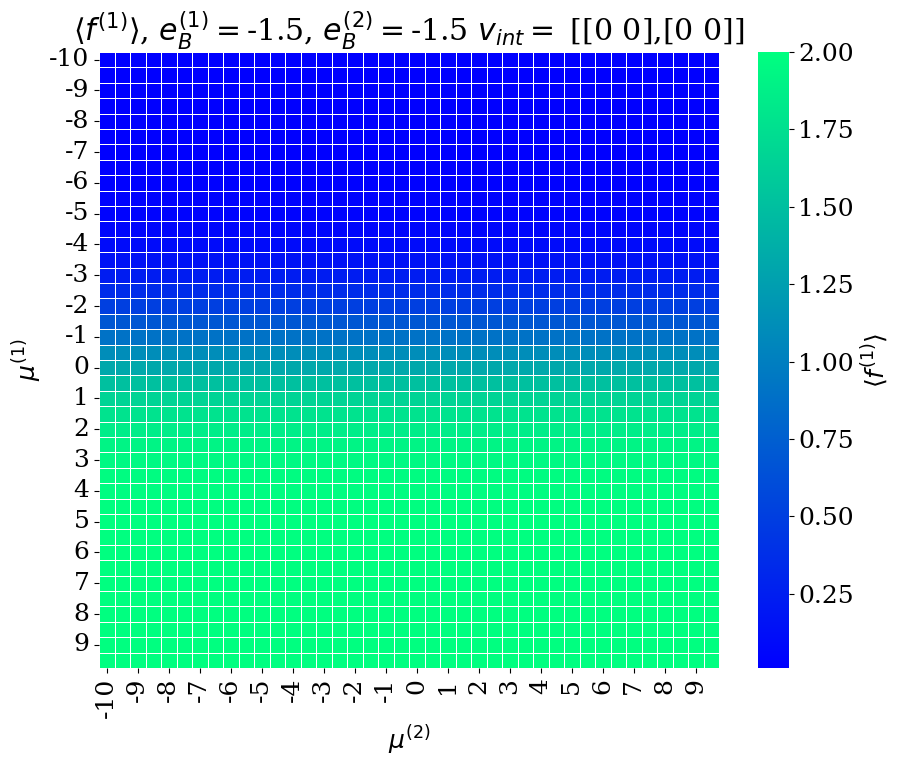

In [982]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])

# protein 1
ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
          str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")

#protein 2
# ax = sns.heatmap(f_gam_soln_arr[1], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(2)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(2)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")



plt.show()


## $\langle s_{i}^{(\gamma_1)} s_{j}^{(\gamma_1')} \rangle$ calculation

In [986]:
# TODO: need to consider possibiltiy of two solutions- need to compare free energy of higher and lower soln

mu = np.array([-2, 1])

f1 = f_gam_soln_arr[0][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]
f2 = f_gam_soln_arr[1][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]

f_bars = [f1, f2]
# s_bnd = np.zeros(6)
# for i in range(n_bind*3):
#     s_bnd[i] = s_bind_soln_arr[i][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]
# s_bnd

eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 0)

array([[0.93113605, 0.93113605, 1.47986863, 1.47986863, 1.78051956,
        1.78051956],
       [0.93113605, 0.93113605, 1.47986863, 1.47986863, 1.78051956,
        1.78051956],
       [1.47986863, 1.47986863, 2.35197764, 2.35197764, 2.82980671,
        2.82980671],
       [1.47986863, 1.47986863, 2.35197764, 2.35197764, 2.82980671,
        2.82980671],
       [1.78051956, 1.78051956, 2.82980671, 2.82980671, 3.40471181,
        3.40471181],
       [1.78051956, 1.78051956, 2.82980671, 2.82980671, 3.40471181,
        3.40471181]])

## sf2 calc

In [987]:
def calc_sf2_chromo(poly_marks, N_m, b, M2s, k_vec = np.logspace(-3, 2, 50)):
    M2_AA, M2_AB, M2_BA, M2_BB, M1_cgam0, M1_cgam1, M2_cc = M2s
#     print(k_vec[0])
    M = np.shape(M2_AA)[0]
    nk = len(k_vec)
    N = M*N_m
        
    grid = np.indices((M, M))
    j1 = grid[0]
    j2 = grid[1]

    S2_AA_arr = np.zeros(nk)
    S2_AB_arr = np.zeros(nk)
    S2_BA_arr = np.zeros(nk)
    S2_BB_arr = np.zeros(nk)
    
    S2_cgam0_arr = np.zeros(nk)
    S2_cgam1_arr = np.zeros(nk)
    S2_cc_arr = np.zeros(nk)

    for i, k in enumerate(k_vec):
        C = np.zeros((M, M))
        k = np.linalg.norm(k)
        x_m = (1/6) * N_m * b**2 * k**2

        #j1 = j2, s1 > s2
        index = (j1 == j2)
        constant = 1
        debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) 
        
        C[np.where((index) != 0)] += debye
        
        #j1 > j2, s1 s2 any
        index = (j1 > j2)
        constant = np.exp(-x_m*(j1-j2))
        integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
        
        #j2 > j1, s1 s2 any
        index = (j2 > j1)
        constant = np.exp(-x_m*(j2-j1))
#         integral is the same

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral   
#         print(C/M**2)
        S2_AA_arr[i] = np.sum((1/M**2) * C * M2_AA)
        S2_AB_arr[i] = np.sum((1/M**2) * C * M2_AB)
        S2_BA_arr[i] = np.sum((1/M**2) * C * M2_BA)
        S2_BB_arr[i] = np.sum((1/M**2) * C * M2_BB)
        
        S2_cgam0_arr[i] = np.sum((1/M**2) * C * M1_cgam0)
        S2_cgam1_arr[i] = np.sum((1/M**2) * C * M1_cgam1)
        S2_cc_arr[i] = np.sum((1/M**2) * C * M2_cc)

    return S2_AA_arr*N**2, S2_AB_arr*N**2, S2_BA_arr*N**2, S2_BB_arr*N**2, S2_cgam0_arr*N**2, S2_cgam1_arr*N**2, S2_cc_arr*N**2


In [994]:
# TODO: need to consider possibiltiy of two solutions- need to compare free energy (gen sfs) of higher and lower soln

mu = np.array([-2, 1]) #chemical potential in solution

k_vec = np.logspace(-3, 2, 50)

f1 = f_gam_soln_arr[0][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]
f2 = f_gam_soln_arr[1][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]

f_bars = [f1, f2]

s_bnd = np.zeros(6)
for i in range(n_bind*3):
    s_bnd[i] = s_bind_soln_arr[i][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]

#TODO confirm these indices are correct
indices_0 = np.tile(marks_1, (len(marks_1),1)).T
# indices_0 = np.outer(marks_1, np.ones(len(marks_1)))
indices_1 = np.tile(marks_2, (len(marks_2),1)).T + 3
# indices_1 = np.outer(marks_2, np.ones(len(marks_2))) + 3

cc = np.ones((len(marks_1), len(marks_1)))

s_cgam0 = s_bnd[indices_0]
s_cgam1 = s_bnd[indices_1]

sisj_AA = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 0)
sisj_AB = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 1)
sisj_BA = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 1, 0)
sisj_BB = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 1, 1)
M2s = [sisj_AA,sisj_AB,sisj_BA,sisj_BB, s_cgam0, s_cgam1, cc]


N_m = 1e3
b = 1
N = N_m * np.shape(sisj_AA)[0]
[S2_AA_arr, S2_AB_arr, S2_BA_arr, S2_BB_arr, S2_cgam0_arr, S2_cgam1_arr, S2_cc_arr] = phi_c * np.array(calc_sf2_chromo(poly_marks, N_m, b, M2s))

# [S2_AA_arr, S2_AB_arr, S2_BA_arr, S2_BB_arr, S2_cgam0_arr, S2_cgam1_arr, S2_cc_arr] = phi_c * np.array([S2_AA_arr, S2_AB_arr, S2_BA_arr, S2_BB_arr, S2_cgam0_arr, S2_cgam1_arr, S2_cc_arr] )

C:\Users\tmhab\AppData\Local\Temp\ipykernel_20168\289184773.py:35: RuntimeWarning: overflow encountered in exp
  constant = np.exp(-x_m*(j1-j2))
C:\Users\tmhab\AppData\Local\Temp\ipykernel_20168\289184773.py:43: RuntimeWarning: overflow encountered in exp
  constant = np.exp(-x_m*(j2-j1))
C:\Users\tmhab\AppData\Local\Temp\ipykernel_20168\289184773.py:36: RuntimeWarning: overflow encountered in exp
  integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms
C:\Users\tmhab\AppData\Local\Temp\ipykernel_20168\289184773.py:38: RuntimeWarning: invalid value encountered in multiply
  C[np.where((index) != 0)] += constant[np.where(index != 0)] \
C:\Users\tmhab\AppData\Local\Temp\ipykernel_20168\289184773.py:46: RuntimeWarning: invalid value encountered in multiply
  C[np.where((index) != 0)] += constant[np.where(index != 0)] \


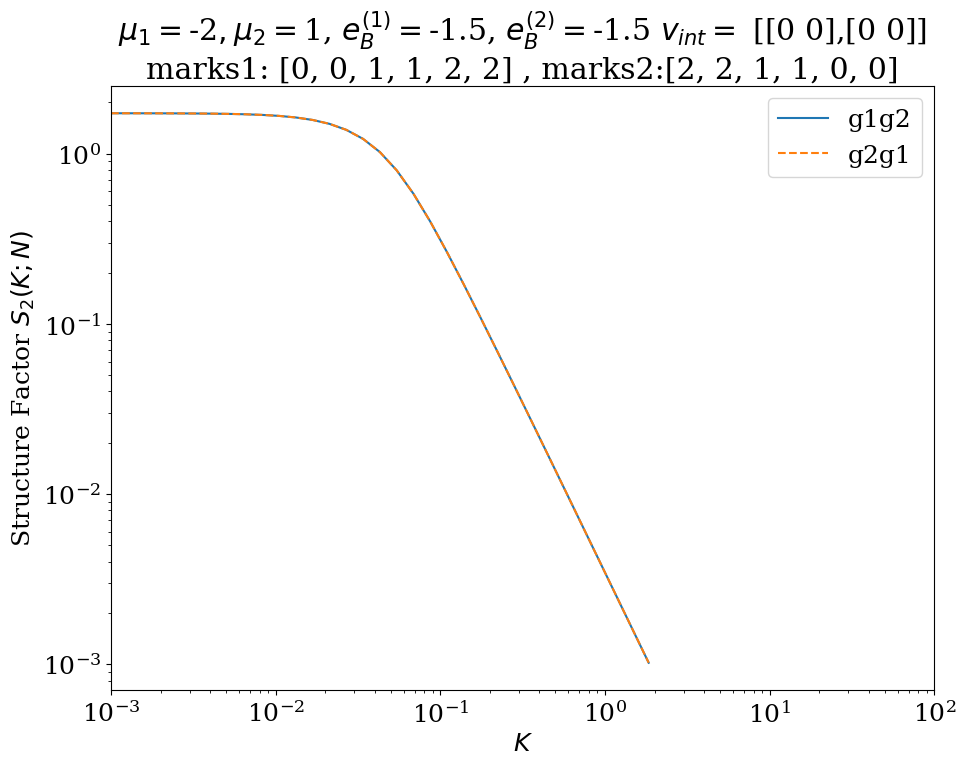

In [995]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.plot(k_vec, S2_AA_arr/N**2, label = "g1g1", linestyle = "-")
# plt.plot(k_vec, S2_BB_arr/N**2, label = "g2g2", linestyle = "--")
plt.plot(k_vec, S2_AB_arr/N**2, label = "g1g2", linestyle = "-")
plt.plot(k_vec, S2_BA_arr/N**2, label = "g2g1", linestyle="--")

# plt.plot(k_vec, S2_cgam0_arr/N**2, label = "cg1", linestyle = "-")
# plt.plot(k_vec, S2_cgam1_arr/N**2, label = "cg2", linestyle = "--")
# plt.plot(k_vec, S2_cc_arr/N**2, label = "cc", linestyle = "-")
# plt.plot(k_vec, [1-phi_c]*len(k_vec), label = "ss", linestyle = "-")

# plt.hlines(phi_c*4, 0.001, 100, color = "blue", linestyle = "--", label = "$4\phi_c$")
# plt.hlines(phi_c*2, 0.01, 100, color = "orange", linestyle = "--", label = "$2\phi_c$")
# plt.hlines(phi_c, 0.01, 100, color = "green", linestyle = "--", label = "$\phi_c$")
# plt.hlines(1-phi_c, 0.01, 100, color = "red", linestyle = "--", label = "$1-\phi_c$")

# low = 35
# high = 39
# plt.plot(k_vec[low:high], 0.5*k_vec[low:high]**-2, linestyle = "--", color = "grey")

# plt.text(5, 0.0035, '$k^{-2}$')
# plt.text(5.5, 0.0015, '$k^{-2}$')

plt.xscale('log')
plt.yscale('log')

# plt.title("S2")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-3, 1e2))

# plt.title("$v_{int} = $" + str(v_int) +  ", $e_B^{(1)} = $" + str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) + "$, \mu_1 = $" + str(mu[0]) \
#           + "$, \mu_2 = $" + str(mu[1]))

plt.title(r"$\mu_1 = $" + str(mu[0]) \
          + "$, \mu_2 = $" + str(mu[1]) +", $e_B^{(1)} = $" + \
          str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))

plt.tight_layout()
# plt.legend()
plt.legend(bbox_to_anchor=(1., 1.0))
plt.show()

## stability analysis

In [996]:
# k = 2
# chi = 1
# g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = calc_sf2_chromo(poly_marks, N_m, b, M2s, [k])
# g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = np.array([g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc])*phi_c
# ss = 1-phi_c
# S2_mat = 0.5 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                 [0, ss, 0, 0], \
#                 [cg1[0], 0, g1g1[0], g1g2[0]],\
#                 [cg2[0], 0, g2g1[0], g2g2[0]]])

# S2_inv = np.linalg.inv(S2_mat)

# # int_mat = np.array[[0,chi,0,0],\
# #                    [chi,0,0,0],\
# #                    [0,0,v_int[0,0], v_int[0,1]],\
# #                    [0,0,v_int[1,0], v_int[1,1]]]

# G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
#                [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])
# # eigenvalue decomp
# val, vec = np.linalg.eigh(G2)
# val

In [ ]:
chi = 0

# min_eigval_arr = np.zeros((len(mu1_array), len(mu2_array), len(k_vec[:40:])))
# 
min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:20:1])))
# min_eigval_arr_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:45:1])))
min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:20:1])))
min_eigval_arr_soln1prot = np.zeros((len(mu1_array[:]),  len(mu2_array[:]), len(k_vec[:20:1])))

det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:20:1])))

# max_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:45:1])))

for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
        mu = [mu1, mu2]
        f1 = f_gam_soln_arr[0][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]
        f2 = f_gam_soln_arr[1][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]

        f_bars = [f1, f2]

        s_bnd = np.zeros(6)
        for b in range(n_bind*3):
            s_bnd[b] = s_bind_soln_arr[b][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]

        #TODO confirm these indices are correct
        indices_0 = np.tile(marks_1, (len(marks_1),1)).T
        indices_1 = np.tile(marks_2, (len(marks_2),1)).T + 3

        cc = np.ones((len(marks_1), len(marks_1)))

        s_cgam0 = s_bnd[indices_0]
        s_cgam1 = s_bnd[indices_1]

        sisj_AA = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 0)
        sisj_AB = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 1)
        sisj_BA = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 1, 0)
        sisj_BB = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 1, 1)
        M2s = [sisj_AA,sisj_AB,sisj_BA,sisj_BB, s_cgam0, s_cgam1, cc]

#         N_m = 1
#         b = 1
#         N = N_m * np.shape(sisj_AA)[0]
        for ik, k in enumerate(k_vec[0:20:1]):
#             print("k:", k)
            g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = phi_c * np.array(calc_sf2_chromo(poly_marks, N_m, b, M2s, [k]))
            
            # SOLUTION analysis
            ss = 1-phi_c
            S2_mat = np.array([[cc[0], 0, cg1[0], cg2[0]],\
                            [0, ss, 0, 0], \
                            [cg1[0], 0, g1g1[0], g1g2[0]],\
                            [cg2[0], 0, g2g1[0], g2g2[0]]])
            
#             S2_mat = np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g2g1[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])
        
#             S2_mat =  1 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])
#             print(S2_mat)
            S2_inv = np.linalg.inv(S2_mat)

            G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
               [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
               [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])
            det = np.linalg.det(G2)
            det_arr[i][j][ik] = det
#             print(det)

            val, vec = np.linalg.eigh(G2)

            min_val = np.min(val)
            max_val = np.max(val)
            
            min_eigval_arr[i][j][ik] = min_val
            max_eigval_arr[i][j][ik] = max_val  #use max because, if one eigval is positive, 

            
#             if ((mu1 == 7 and (mu2 == 7)) or (mu1 == -7 and (mu2 == -7))) and k == k_vec[0]:
#                 print("[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]")
#                 print("mu: ", mu)
#                 print("k = ", k)
#                 print("----------------------------")
#                 print("solution")
#                 print("S2: ", S2_mat)
#                 print("g2:", G2)
# #                 print("det: ", det)
#                 print("vals: ", val)
# #                 print("hehehehehehehehehehehehehehhehehehehehehehehehehehehehehehehee")
# #                 print("new analysis, delg1 = delg2 incomp cond for symmetric system (mu1=mu2, eb1=eb2, marks1=marks2)")
# #                 S2_mat = np.array([[cc[0], 0, 2*cg1[0]],\
# #                                 [0, ss, 0], \
# #                                 [2*cg1[0], 0, 4*g1g1[0]]])

# #                 S2_inv = np.linalg.inv(S2_mat)
# #                 G2 = S2_inv 
# #                 det = np.linalg.det(G2)
# #                 val, vec = np.linalg.eigh(G2)
# #                 print("S2: ", S2_mat)
# #                 print("g2:", G2)
# # #                 print("det: ", det)
# #                 print("vals: ", val)
# # #             print(det)
 
#             if ((mu1 == 7 and (mu2 == 6 or mu2 == 7)) or (mu1 == -7 and (mu2 == -6 or mu2 == -7))) and k == k_vec[0]:
            if ((mu1 == -2 and (mu2 == -2 or mu2 == -1)) and k == k_vec[0]):
                print("[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]")
                print("mu: ", mu)
                print("k = ", k)
                print("----------------------------")
                print("solution")
                print("S2: ", S2_mat)
                print("g2:", G2)
                print("det: ", det)
                print("vals: ", val)

                
                
                
#             SOLUTION ONE READER PROTEIN v_int = 0000 chi = 0

#             S2_mat = np.array([[cc[0], 0, cg1[0]],\
#                             [0, ss, 0], \
#                             [cg1[0], 0, g1g1[0]]])

#             S2_inv = np.linalg.inv(S2_mat)
        
#             G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2]],\
#                [S2_inv[2,0], S2_inv[2,2]+v_int[0][0]]])
# #             det = np.linalg.det(G2)
# #             det_arr[i][j][ik] = det
# #             print(det)

#             val, vec = np.linalg.eigh(G2)

#             min_val = np.min(val)
#             min_eigval_arr_soln1prot[i][j][ik] = min_val

            
#             MELT analysis 2 reader proteins (BUT not really melt UNLESS rerun all with phi_c = 1)
            

#             S2_mat = np.array([[cc[0], cg1[0], cg2[0]],\
#                             [cg1[0], g1g1[0], g1g1[0]],\
#                             [cg2[0], g1g1[0], g1g1[0]]])
# #             S2_mat = np.array([[cc[0], cg1[0], cg2[0]],\
# #                             [cg1[0], g1g1[0], g1g2[0]-1],\
# #                             [cg2[0], g2g1[0]-1, g2g2[0]]])
#             print("k: ", k)
#             print(S2_mat)
#             S2_inv = np.linalg.inv(S2_mat)

#             G2 = S2_inv + \
#             np.array([[0, 0, 0],\
#                [0, v_int[0,0], v_int[0,1]],\
#                [0,  v_int[1,0], v_int[1,1]]])
            
#             val, vec = np.linalg.eigh(G2)
#             if ((mu1 == 7 and (mu2 == 6 or mu2 == 7)) or (mu1 == -7 and (mu2 == -6 or mu2 == -7))) and k == k_vec[15]:
#                 print("[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]")
#                 print("mu: ", mu)
#                 print("k = ", k)
#                 print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#                 print("melt")
#                 print("S2: ", S2_mat)
#                 print("g2:", G2)
#                 print("vals: ", val)

#             min_val = np.min(val)
            
#             min_eigval_arr_melt[i][j][ik] = min_val
            
     
        
        
#             # POLY/SOLV only, no binding analysis 
            
#             ss = 1-phi_c
#             S2_mat = np.array([[cc[0], 0], [0, ss]])
            
#             S2_inv = np.linalg.inv(S2_mat)

#             G2 = np.array([S2_inv[0,0] - 2*chi + S2_inv[1,1]])
            
#             val = G2[0]#vec = np.linalg.eigh(G2)
            
#             if mu1 == 7 and (mu2 == 6 or mu2 == 7) and k == k_vec[0]:
#                 print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#                 print("poly solv no binding")
#                 print("S2: ", S2_mat)
#                 print("g2:", G2)
#                 print("vals: ", val)
                
#             min_eigval_arr_ps[i][j][ik] = val
#             if min_val <= 0

[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
mu:  [-2.0, -2.0]
k =  0.001
----------------------------
solution
S2:  [[2.14211194e+07 0.00000000e+00 1.03246054e+06 1.03246054e+06]
 [0.00000000e+00 4.00000000e-01 0.00000000e+00 0.00000000e+00]
 [1.03246054e+06 0.00000000e+00 4.49264595e+07 4.49008892e+07]
 [1.03246054e+06 0.00000000e+00 4.49008892e+07 4.49264595e+07]]
g2: [[ 2.50000005e+00 -5.37160625e-10 -5.37160625e-10]
 [-5.37160625e-10  1.95595255e-05 -1.95483807e-05]
 [-5.37160625e-10 -1.95483807e-05  1.95595255e-05]]
det:  1.0896259796496381e-12
vals:  [1.11448151e-08 3.91079061e-05 2.50000005e+00]
[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
mu:  [-2.0, -1.0]
k =  0.001
----------------------------
solution
S2:  [[2.14211194e+07 0.00000000e+00 1.03246054e+06 3.66065635e+06]
 [0.00000000e+00 4.00000000e-01 0.00000000e+00 0.00000000e+00]
 [1.03246054e+06 0.00000000e+00 4.49264595e+07 5.71027404e+07]
 [3.66065635e+06 0.00000000e+00 5.71027404e+07 

In [819]:
40*20

800

In [710]:
def gam2_polysolv(poly_marks, N_m, b, M2s, k):
    g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = phi_c * np.array(calc_sf2_chromo(poly_marks, N_m, b, M2s, k))    
    ss = 1-phi_c
    S2_mat = np.array([[cc[0], 0], [0, ss]])

    S2_inv = np.linalg.inv(S2_mat)
    chi = 0
    G2 = np.array([N*S2_inv[0,0] - 2*chi + N*S2_inv[1,1]])
    return G2

KS = opt.fmin(lambda K: np.real(gam2_polysolv(poly_marks, N_m, b, M2s, [k])), 0.001,\
                  disp=False)
KS

array([0.001])

In [722]:
# poly/solv key analysis

#solvent strucutre afctor normailization wrong, but still getting stability of mixed system at chi = 0
chi = 0

k = 0.001
g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = phi_c * np.array(calc_sf2_chromo(poly_marks, N_m, b, M2s, [k]))

ss = 1-phi_c

S2_mat = np.array([[cc[0], 0], [0, 1*ss]])
S2_mat = np.array([[cc[0], 0, 0.0001], [0, 1*ss, 0.0001], [0,0,0.0001]]) #proof of concept
# S2_mat = np.array([[cc[0], 0, 0.0001], [0, 100000*ss, 0.0001], [0,0,0.0001]]) #goal
# S2_mat = np.array([[cc[0], 0, 0.01], [0, 0.00001*ss, 0.01], [0,0,0.01]]) # current

S2_inv = np.linalg.inv(S2_mat)

G2 = np.array([N*S2_inv[0,0] - 2*chi + N*S2_inv[1,1]])

val = G2[0]#vec = np.linalg.eigh(G2)
print(val)

15000.000280097407


In [715]:
S2_mat

array([[2.14211194e+07, 0.00000000e+00, 1.00000000e-02],
       [0.00000000e+00, 4.00000000e-06, 1.00000000e-02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e-02]])

In [611]:
KS

array([0.01])

In [598]:
N

600000.0

In [471]:
s222 = np.array([[21.59928454,0.,43.17493707,43.17493707],
 [ 0.,0.4,0.,0.],
 [43.17493707,  0.  , 86.39522506, 86.3952214 ],
 [43.17493707,  0.,    86.3952214,  86.39522506]])
np.linalg.det(s222)

5.855468408520635e-06

In [465]:
s333 = np.array([[21.6 , 0.,  43.2 ,43.2],
 [ 0.  , 0.4 , 0. ,  0. ],
 [43.2,  0. , 86.4 ,86.4],
 [43.2,  0.,  86.4 ,86.4]]
)
# np.linalg.inv(s333)
np.linalg.det(s333)

0.0

In [477]:
ss = 1-phi_c
cc = phi_c
cg1 = 2*phi_c
cg2 = cg1
g1g1 = 4*phi_c
g1g2 = g1g1
g2g1 = g1g1
g2g2 = g1g1


S2_mat = N**2 * np.array([[cc, 0, cg1, cg2],\
                [0, ss/N**2, 0, 0], \
                [cg1, 0, g1g1, g1g2],\
                [cg2, 0, g2g1, g2g2]])
print(S2_mat)
# S2_inv = np.linalg.inv(S2_mat)

# G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#    [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
#    [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])


#melt
# S2_mat = N**2 * np.array([[cc, cg1, cg2],\
#                 [cg1, g1g1, g1g2],\
#                 [cg2, g2g1, g2g2]])

s2melt = np.array([[21.59928454,43.17493707,43.17493707],
 [43.17493707, 86.39522506, 86.3952214 ],
 [43.17493707, 86.3952214,  86.39522506]])


print(s2melt, "Poo")
S2_inv = np.linalg.inv(s2melt)

val, vec = np.linalg.eigh(S2_inv)
print(min(val))
# G2 = np.array([[S2_inv[0,0], S2_inv[0,1], S2_inv[0,]],\
#    [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
#    [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])

# val, vec = np.linalg.eigh(G2)

[[21.6  0.  43.2 43.2]
 [ 0.   0.4  0.   0. ]
 [43.2  0.  86.4 86.4]
 [43.2  0.  86.4 86.4]]
[[21.59928454 43.17493707 43.17493707]
 [43.17493707 86.39522506 86.3952214 ]
 [43.17493707 86.3952214  86.39522506]] Poo
0.005144843003344057


In [437]:
# #density maps
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# # plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 0
# ax = sns.heatmap(np.sign(max_eigval_arr[:,:,k_ind]), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# # ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# # protein 1
# # ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ sign \ of \ \lambda_{max}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
#           str(chi) \
#           +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")


# plt.show()


In [793]:
# det_arr

In [815]:
# #density maps
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# # plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 0
# ax = sns.heatmap(det_arr[:,:,k_ind], linewidth=0.25, cmap = "summer", xticklabels=mu2_array, yticklabels=mu1_array)
# # ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# # protein 1
# # ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ |\Gamma_2|, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
#           str(chi) \
#           +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")


# plt.show()


In [ ]:
plt.plot(min_eigval_arr_soln1prot)

<Figure size 640x480 with 0 Axes>

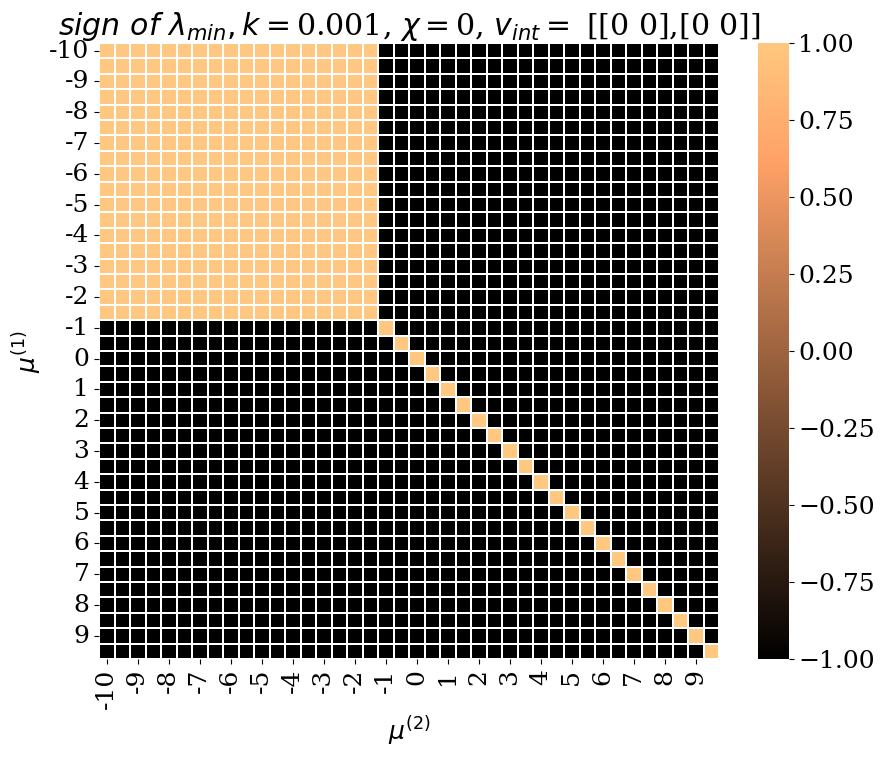

In [998]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(np.sign(min_eigval_arr[:,:,k_ind]), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ sign \ of \ \lambda_{min}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")


plt.show()


<Figure size 640x480 with 0 Axes>

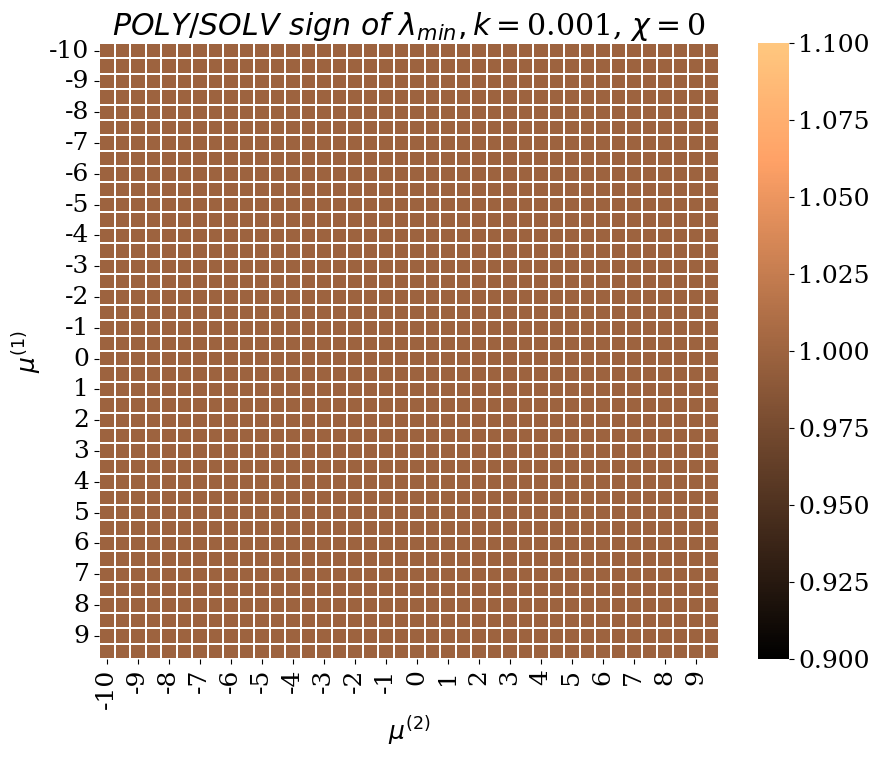

In [826]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(np.sign(min_eigval_arr_ps[:,:,k_ind]), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ POLY/SOLV \  sign \ of \ \lambda_{min}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi))


plt.show()


<Figure size 640x480 with 0 Axes>

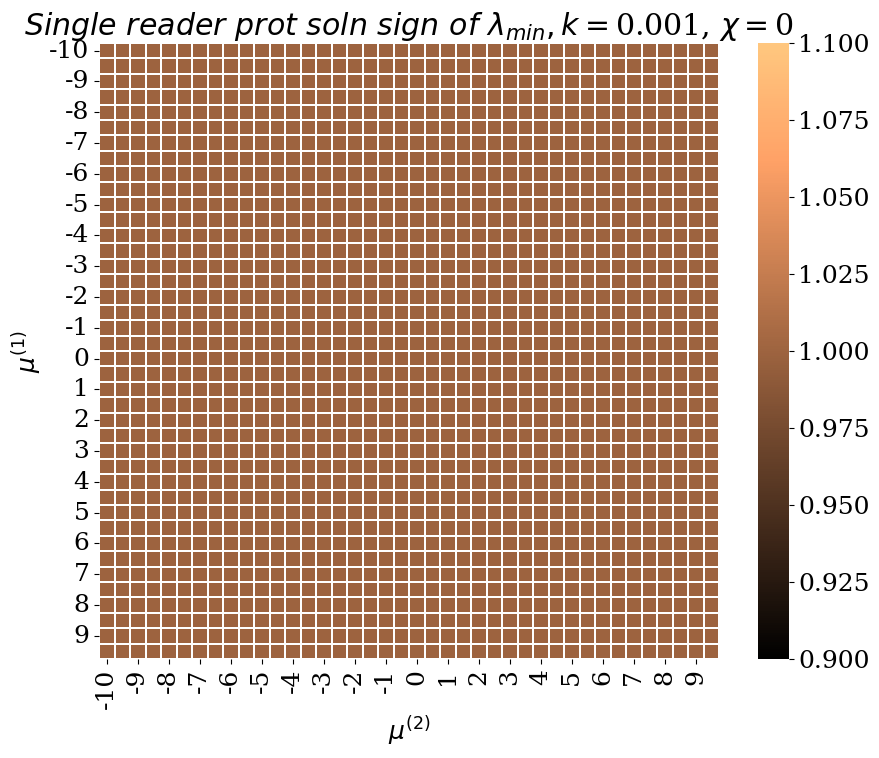

In [822]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(np.sign(min_eigval_arr_soln1prot[:,:,k_ind]), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ Single \ reader \ prot \ soln \  sign \ of \ \lambda_{min}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi))


plt.show()


<Figure size 640x480 with 0 Axes>

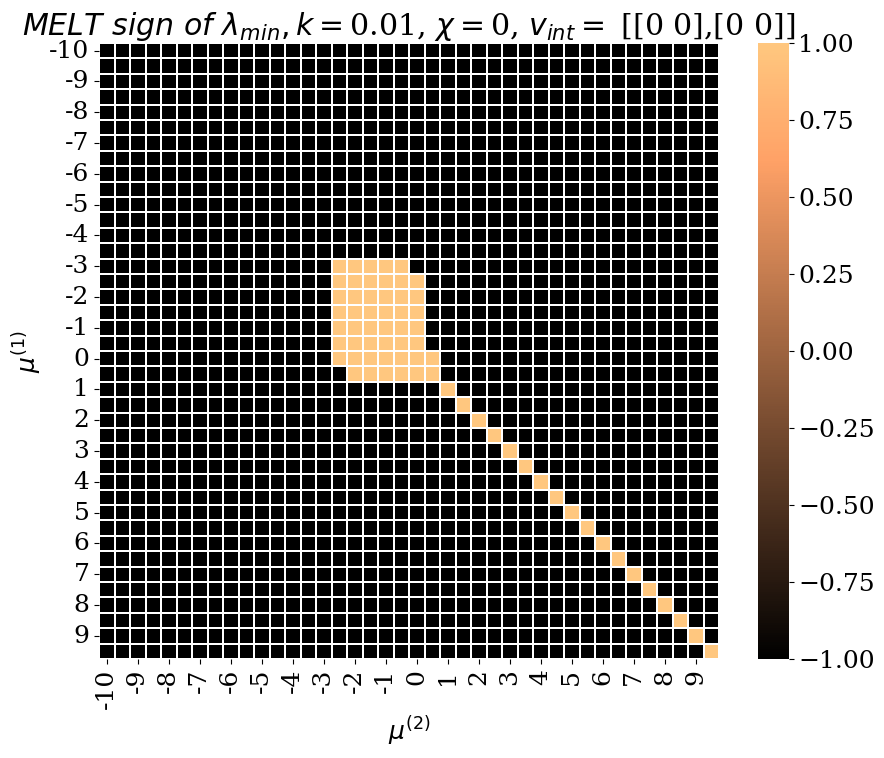

In [482]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(np.sign(min_eigval_arr_melt[:,:,k_ind]), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ MELT \  sign \ of \ \lambda_{min}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")


plt.show()


In [ ]:
# WHAT IS UNIQUE ABOUT THOSE stable points. Look at what changes when crossing over from mu = 7,7 to mu = 7,6

In [792]:
import sympy as sym
cc, ss, cg1, cg2, g1g1, g1g2, g2g1, g2g2 = sym.symbols("cc, ss, cg1, cg2, g1g1, g1g2, g2g1, g2g2")
# M = sym.Matrix([[cc, 0, cg1, cg1],\
#                 [0, ss, 0, 0], \
#                 [cg1, 0, g1g1, g1g1],\
#                 [cg1, 0, g1g1, g1g1]])
# Minv = M.inv()
# Minv.applyfunc(sym.simplify)

# applying delt g1 = delt g2 for sym sys
M = sym.Matrix([[cc, 0, 2*cg1],\
                [0, ss, 0,], \
                [2*cg1, 0, 4*g1g1]])
Minv = M.inv()
Minv.applyfunc(sym.simplify)
Minv.eigenvals()

{(cc + 4*g1g1)/(8*(cc*g1g1 - cg1**2)) - sqrt(cc**2 - 8*cc*g1g1 + 16*cg1**2 + 16*g1g1**2)/(8*(cc*g1g1 - cg1**2)): 1,
 (cc + 4*g1g1)/(8*(cc*g1g1 - cg1**2)) + sqrt(cc**2 - 8*cc*g1g1 + 16*cg1**2 + 16*g1g1**2)/(8*(cc*g1g1 - cg1**2)): 1,
 1/ss: 1}

In [827]:
cc, ss, cg1, cg2, g1g1, g1g2, g2g1, g2g2 = sym.symbols("cc, ss, cg1, cg2, g1g1, g1g2, g2g1, g2g2")
M = sym.Matrix([[cc, 0, cg1, cg2],\
                [0, ss, 0, 0], \
                [cg1, 0, g1g1, g1g2],\
                [cg2, 0, g1g2, g2g2]])
Minv = M.inv()
Minv.applyfunc(sym.simplify)

Matrix([
[(-g1g1*g2g2 + g1g2**2)/(-cc*g1g1*g2g2 + cc*g1g2**2 + cg1**2*g2g2 - 2*cg1*cg2*g1g2 + cg2**2*g1g1),    0, (cg1*g2g2 - cg2*g1g2)/(-cc*g1g1*g2g2 + cc*g1g2**2 + cg1**2*g2g2 - 2*cg1*cg2*g1g2 + cg2**2*g1g1), (-cg1*g1g2 + cg2*g1g1)/(-cc*g1g1*g2g2 + cc*g1g2**2 + cg1**2*g2g2 - 2*cg1*cg2*g1g2 + cg2**2*g1g1)],
[                                                                                               0, 1/ss,                                                                                               0,                                                                                                0],
[ (cg1*g2g2 - cg2*g1g2)/(-cc*g1g1*g2g2 + cc*g1g2**2 + cg1**2*g2g2 - 2*cg1*cg2*g1g2 + cg2**2*g1g1),    0,   (-cc*g2g2 + cg2**2)/(-cc*g1g1*g2g2 + cc*g1g2**2 + cg1**2*g2g2 - 2*cg1*cg2*g1g2 + cg2**2*g1g1),    (cc*g1g2 - cg1*cg2)/(-cc*g1g1*g2g2 + cc*g1g2**2 + cg1**2*g2g2 - 2*cg1*cg2*g1g2 + cg2**2*g1g1)],
[(-cg1*g1g2 + cg2*g1g1)/(-cc*g1g1*g2g2 + cc*g1g2**2 + cg1**2*g2g2 - 2*cg1*cg2*g1g2 + cg2

In [386]:
# # 1D solution plotting
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)
    

# # f_bar (single solns ONLY): 
# plt.plot(mu1_array, f_gam_soln_arr[0][:,9], label = r"$ \langle f_{\gamma}^{(1)} \rangle $", color = "blue")
# plt.plot(mu2_array, f_gam_soln_arr[1][6,:], label = r"$ \langle f_{\gamma}^{(2)} \rangle $", color = "green", linestyle = "--")


# # s_bind:
# # plt.plot(mu1_array, s_bind_soln_arr[0][:,0], label = r"$ \langle s_{bind}^{(\gamma_1, \sigma = 0)} \rangle $",)
# # plt.plot(mu1_array, s_bind_soln_arr[1][:,0], label = r"$ \langle s_{bind}^{(\gamma_1, \sigma = 1)} \rangle $",)
# # plt.plot(mu1_array, s_bind_soln_arr[2][:,0], label = r"$ \langle s_{bind}^{(\gamma_1, \sigma = 2)} \rangle $",)

# # plt.plot(mu2_array, s_bind_soln_arr[3][0,:], label = r"$ \langle s_{bind}^{(\gamma_2, \sigma = 0)} \rangle $",)
# # plt.plot(mu2_array, s_bind_soln_arr[4][0,:], label = r"$ \langle s_{bind}^{(\gamma_2, \sigma = 1)} \rangle $",)
# # plt.plot(mu2_array, s_bind_soln_arr[5][0,:], label = r"$ \langle s_{bind}^{(\gamma_2, \sigma = 2)} \rangle $",)


# # # LANGMUIR. Assumptions only valid when v_int = 0, and for sigma =0 or 2 (all sites identical)
# # K = np.exp(-e_m[0])
# # plt.plot(mu1_array, 2*K*np.exp(mu1_array) / (1+ K*np.exp(mu1_array)), label = "langmuir", linestyle = ":", color = "black")

# # K = np.exp(-0)  # sigma = 0 - all binding energies are 0
# # plt.plot(mu1_array, 2*K*np.exp(mu1_array) / (1+ K*np.exp(mu1_array)), label = "langmuir, e_b = 0", linestyle = "-.", color = "black")


# plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
# plt.xlabel("$\mu^{(n)} $")
# plt.title(r"$e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
# plt.hlines(1, -10, 10, color = "black", alpha = 0.3)
# # plt.vlines(-.75, 0,2, color = "black", alpha = 0.3, label = "$\mu = -0.75$")
# plt.vlines(-0, 0,2, color = "black", alpha = 0.3, label = "$\mu = 0$")
# plt.legend()

# # why is s_bind = 2 * (exp(x \ (1 + exp)))? how did that realtion come about. it is to allow for unbounded minimizationq
# #check solver- intial conditions? 

In [387]:
# # self-consistent calculation plotting

# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)


# ax = plt.axes(projection='3d')

# X,Y = np.meshgrid(f_gam_arr,f_gam_arr)

# # ax.view_init(0,0)
# # ax.contour3D(X, Y, RHS_arr[0], 100, cmap='rainbow', label = r"$ \langle f_{\gamma_1} \rangle $ RHS")
# # ax.contour3D(X, Y, Y, 50, cmap='binary', label = r"$ \langle f_{\gamma_1} \rangle $ LHS")
# # rainbow_patch = matplotlib.patches.Patch(color='red', label=r"$ \langle f_{\gamma_1} \rangle $ RHS")
# # black_patch = matplotlib.patches.Patch(color='grey', label=r"$ \langle f_{\gamma_1} \rangle $ LHS")
# # #ax.contour3D(X, Y, RHS_arr[0]-Y, 50, cmap='binary')

# ax.view_init(0,-90)
# ax.contour3D(X, Y, RHS_arr[1], 50, cmap='rainbow', label = r"$ \langle f_{\gamma_2} \rangle $ RHS")
# ax.contour3D(X, Y, X, 50, cmap='binary', label = r"$ \langle f_{\gamma_2} \rangle $ LHS")
# rainbow_patch = matplotlib.patches.Patch(color='red', label=r"$ \langle f_{\gamma_2} \rangle $ RHS")
# black_patch = matplotlib.patches.Patch(color='grey', label=r"$ \langle f_{\gamma_2} \rangle $ LHS")
# # #ax.contour3D(X, Y, RHS_arr[1]-X, 50, cmap='binary')

# ax.set_xlabel(r"$ \langle f_{\gamma_2} \rangle $")
# ax.set_ylabel(r"$ \langle f_{\gamma_1} \rangle $")
# # ax.set_zlabel('z')

# # plt.xlabel()
# # plt.title("$v_{int} = $" + str(v_int[0][0]) +  " $,e_B = $" + str(e_m[0]) + ", $\phi_c = $" + str(phi_c) +", $\mu = $" + str(np.round(mu,3)))
# plt.title(r" $\mu = $" +str(mu) +", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], ")
# plt.legend(handles=[rainbow_patch, black_patch])
# plt.show()

In [ ]:
# # single mark, shouldnt need to use

# n_bind = 1 #types of proteins/marks

# e_m = np.array([-1.5]) #binding energy
# # e_m = np.array([-8.5]) #binding energy
# # e_m = np.array([0]) #binding energy
# f_om = np.array([1/3, 1/3, 1/3]) # fraction of nucleosomes with 0,1,2 marks per protein type
# v_int = np.array([[-3.92]]) # protein-protein interaction param
# # v_int = np.array([[-1.8]]) # protein-protein interaction param
# # v_int = np.array([[-8]])
# phi_c = 0.6# avg amount of chromosome 

# x = np.zeros(n_bind * 3)

# # SOLUTION FOR A SINGLE MARK
# #TODO: 
# #  -extend to each sbind var (for cgam sf and to verify correctness by comparing to fbar)
# #       - once have f_bind, self consistently solve for s_binds

# #  - generalize for a range of mu values, TWO reader protein types
# mu = [-5]
# # mu = [8]

# f_gam_arr = np.arange(-0.01,2.02,0.01)
# # f_gam_arr = np.arange(-0.25,2.26,0.25)

# phi_bind_arr = np.zeros(len(f_gam_arr))
# phi_bind_arr = phi_c * f_gam_arr

# RHS = np.zeros(len(f_gam_arr))
# RHS_arr = np.zeros((n_bind, len(f_gam_arr)), dtype = "object")
# for i,f in enumerate(f_gam_arr):
    
#     erg_int = np.matmul(v_int, [phi_bind_arr[i]])
#     for mark in range(n_bind): # for each reader protein/ mark type
#         for om in range(3): # for each possible number of marked tails on nucl
#             f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
#             f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
#             q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])
            
#             RHS = RHS_arr[mark] 
#             RHS[i] += f_om[om+(mark*3)] * (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
#                                          2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q 
#             RHS_arr[mark] = RHS
# RHS_fgam = RHS_arr[0]   

# def zcr(x, y):
#     # find where in x that y changes sign (crosses zero)
#     ind = np.where(np.diff(np.sign(y))!=0)[0]
#     ind += 1
# #     print(ind)
# #     return x[np.diff(np.sign(y)) != 0]
#     return x[ind]

# RHS = RHS_arr[0] 
# f_gam_solns = zcr(f_gam_arr, f_gam_arr-RHS)


# sbind = np.zeros((len(f_gam_solns), n_bind*3))

# for j, f_gam_soln in enumerate(f_gam_solns):
    
#     phi_bind_arr = phi_c * np.array(f_gam_soln)
#     erg_int = np.matmul(v_int, [phi_bind_arr])
    
#     ind = 0
#     for mark in range(n_bind): # for each reader protein/ mark type
#         for om in range(3): # for each possible number of marked tails on nucl
#             f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
#             f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
#             q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])

#             sbind[j, om+mark*3] =  (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
#                                          2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q 
#             ind+=1    
#         ind0 = mark * 3 
#         print("leggo")
#         print(np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)]))
#         print(f_gam_solns[j])
        
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font) 

# plt.plot(f_gam_arr, RHS_fgam, label = "RHS")
# plt.plot(f_gam_arr,f_gam_arr, label = "LHS")
# # plt.plot(f_gam_arr,f_gam_arr-RHS_fgam)
# # plt.hlines(0,2,0, linestyle="--")
# plt.scatter(f_gam_solns, f_gam_solns)

# # plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
# plt.xlabel(r"$ \langle f_{\gamma} \rangle $")
# plt.title("$v_{int} = $" + str(v_int[0][0]) +  " $,e_B = $" + str(e_m[0]) + ", $\phi_c = $" + str(phi_c) +", $\mu = $" + str(np.round(mu,3)))
# plt.legend()